## Name: 張宸愷
## ID: 0710018

## Introduction



## Data collection

## Introduction

## Data Collection

## Preprocessing

## Models
For this kind of problem, I will use Naive Bayes classifier, random forest, and MLPs. 



In [64]:
# Data preprocessing

import sklearn
import numpy as np
import pandas as pd
from nltk import tokenize
import re

# print("sdff")
bait = pd.read_json("bait.json")
non_bait = pd.read_json("not_bait.json")
data = pd.concat([bait, non_bait])
data = [[str.lower(f[0]), f[1]] for f in data.values]



question_phrase = ["what", "when", "where", "are", "is",
                   "how", "why", "can", "should", "could", "were", "was"]
feature_exclamation = ["!" in f[0] for f in data]
feature_isQuestion = []

for f in data:
    s = tokenize.word_tokenize(f[0])
    if len(s) == 0:
        feature_isQuestion.append(False)
        continue
    feature_isQuestion.append("?" in str(f[0]) or (s[0] in question_phrase))
d = []
for f in data:
    s = re.sub(r"[?!`~'\-=\+@/;:\",_@#$%^&]+", "", f[0])
    d.append([s, f[1]])
data = pd.DataFrame([[tokenize.word_tokenize(f[0]), f[1]] for f in d])
print(data)
feature_length = pd.Series([len(f[0]) for f in data.values])

# print(feature_length)


                                                      0  1
0     [donald, trump, is, once, again, in, court, ar...  1
1     [the, federal, government, is, still, undercou...  1
2     [biden, plans, to, talk, about, voting, rights...  1
3     [23, new, fantasy, and, science, fiction, nove...  1
4     [these, photos, show, the, devastating, effect...  1
...                                                 ... ..
4710  [devastated, by, a, tornado, 10, years, ago, j...  0
4711  [can, testtostay, keep, kids, in, schools, saf...  0
4712  [andreas, kluths, view, to, 2022, plague, and,...  0
4713  [mexicos, wheat, fields, help, feed, the, worl...  0
4714  [tensions, with, russia, are, now, spilling, i...  0

[4715 rows x 2 columns]


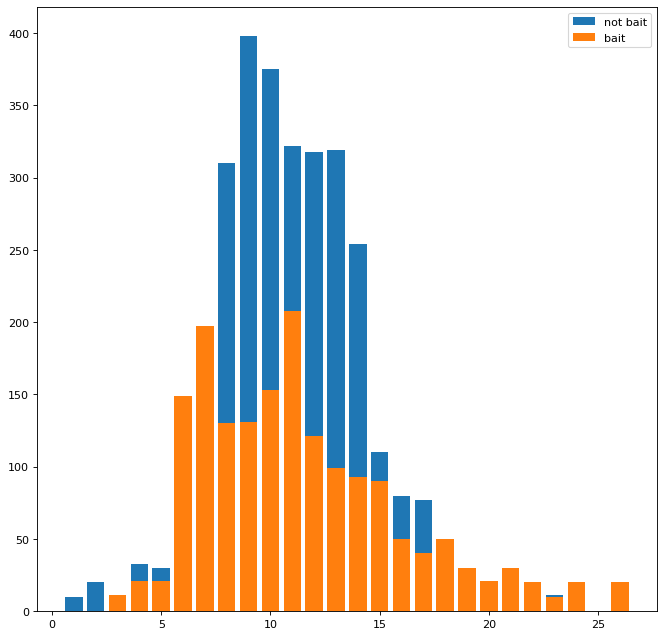

In [67]:
# Data visualization

import matplotlib.pyplot as plt

select_bait = (data[1] == 1)
select_not = (data[1] == 0)
_ = plt.figure(figsize=(10, 10), dpi=80)
bait:pd.Series = feature_length[select_bait].value_counts()
not_bait:pd.Series = feature_length[select_not].value_counts()
_ = plt.bar(not_bait.index.values, not_bait.values, label="not bait")
_ = plt.bar(bait.index.values, bait.values, label="bait")
plt.legend()


# Conclusion